# Getting the data

Below code cells acquire the zip file for cropped images from the dataset ([Road and Building Detection Datasets](https://www.cs.toronto.edu/~vmnih/data/)

**Citation:**

Mnih, V. (2013). *Machine Learning for Aerial Image Labeling*. PhD thesis, University of Toronto.

The dataset is acquired from [Kaggle](https://www.kaggle.com/datasets/balraj98/massachusetts-buildings-dataset) for convenience.

Since the dataset was big (1.4 GB), it took quite a much of time for downloading and un-zipping the dataset. Moreover, the dataset in kaggle contained images in both tiff and png format and thus causing double the storage.

Moreover, images in the dataset were quite large (1500 px, 1500 px) and were impractical to feed to the network as is due to performance considerations.

As a result, it was decided that storing images in the shape of (256, 256) in a Google Drive was a convenient choice.

The mentioned Preprocessing steps were done in the following notebook: [building image preprocessing](https://github.com/gunaykrgl/buildingSegmentation/blob/f902a2f28c65ab40ca12bcfb00fd0b09af2221f4/(edited%20at%2003.03.2024)%20-%20Building%20getting%20and%20preprocessing%20input%20from%20kaggle.ipynb)



In [1]:
# Get the data (of preprocessed .tiff images and .tif
# masks with the width and height of 256) from Google drive

from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/buildingSegmentation/cropped_data_v4.zip data.zip
!unzip -qq data.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Libraries

import tensorflow as tf
import numpy as np
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy, BinaryCrossentropy
from keras.metrics import categorical_accuracy, MeanIoU
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Concatenate, BatchNormalization, Dropout, Conv2DTranspose

from PIL import Image
import matplotlib.pyplot as plt

import glob
import pickle
import random

# Exploratory Data Analysis

The following code cell ensures that number of mask and image files for each of train, validation and test folders is the same. Moreover, it also checks whether lists hold correct paths by checking the first element of each list.

In [4]:
# # These are only filenames
train_x = sorted(glob.glob("train/image_*.tiff"))
train_y = sorted(glob.glob("train/mask_*.tif"))

val_x = sorted(glob.glob("val/image_*.tiff"))
val_y = sorted(glob.glob("val/mask_*.tif"))

test_x = sorted(glob.glob("test/image_*.tiff"))
test_y = sorted(glob.glob("test/mask_*.tif"))

print(len(train_x), len(train_y), len(val_x), len(val_y), len(test_x), len(test_y))
print(train_x[0], train_y[0], val_x[0], val_y[0], test_x[0], test_y[0])

3106 3106 100 100 250 250
train/image_1.tiff train/mask_1.tif val/image_1.tiff val/mask_1.tif test/image_1.tiff test/mask_1.tif


Since dataset is big, loading it all in once is inefficient and costly to the memory. Therefore, a data generator is used to load data as batches of 32.

In [5]:
from keras.utils import Sequence
import os
import glob
class DataGenerator(Sequence):
  def __init__(self, directory, batch_size=32, image_size=(256, 256)):
        self.directory = directory
        self.batch_size = batch_size
        self.image_size = image_size
        self.image_paths = sorted(glob.glob(os.path.join(directory, 'image*')))
        self.mask_paths = sorted(glob.glob(os.path.join(directory, 'mask*')))
        self.indexes = np.arange(len(self.image_paths))

  def __len__(self):
    return int(len(self.image_paths) / self.batch_size)

  def __getitem__(self, index):
    start = index * self.batch_size
    end = (index + 1) * self.batch_size

    batch_image_paths = self.image_paths[start:end]
    batch_mask_paths = self.mask_paths[start:end]

    X, y = self.load_data(batch_image_paths, batch_mask_paths)
    return X, y

  def load_data(self, image_paths, mask_paths, normalize = True):
    X = np.zeros((len(image_paths), 256, 256, 3), dtype=np.float64)
    y = np.zeros((len(image_paths), 256, 256, 1), dtype=np.float64)
    for i, (img, mask) in enumerate(zip(image_paths, mask_paths)):
      X[i] = np.array(Image.open(img))
      y[i] = np.array(Image.open(mask)).reshape(256, 256, 1)

    if normalize:
      X, y = X / 255.0, y / 255.0

    return X, y

  def on_epoch_end(self):
    pass

In [6]:
# Define data generators for train, test and validation datasets

trainGen = DataGenerator("train")
valGen = DataGenerator("val")
testGen = DataGenerator("test")

In [10]:
# [batch id, image|mask, index inside the batch ,data]
print(trainGen[0][0].shape)  # (32, 256, 256, 3) --> (samples inside the batch, height, width, RGB (color channels))
print(len(trainGen)) # 97 batches ~~ 3106 / 32 (#images in train folder / #batchSize)

(32, 256, 256, 3)
97


## Sample images

The following cell tests data generators by getting a random data from all 3 datagenerators.

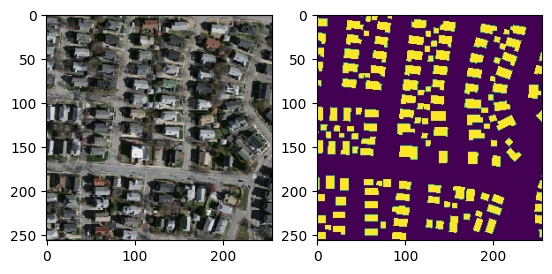

In [30]:
# For Train

randomImageBatch, randomMaskBatch = random.choice(trainGen)

k = random.randint(0, 31)

fig, axes = plt.subplots(1, 2)

axes[0].imshow(randomImageBatch[k])
axes[1].imshow(randomMaskBatch[k])

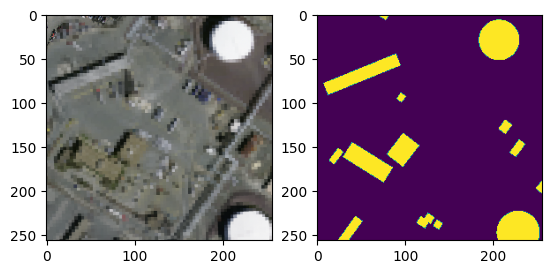

In [26]:
# For Validation

randomImageBatch, randomMaskBatch = random.choice(valGen)

k = random.randint(0, 31)

fig, axes = plt.subplots(1, 2)

axes[0].imshow(randomImageBatch[k])
axes[1].imshow(randomMaskBatch[k])

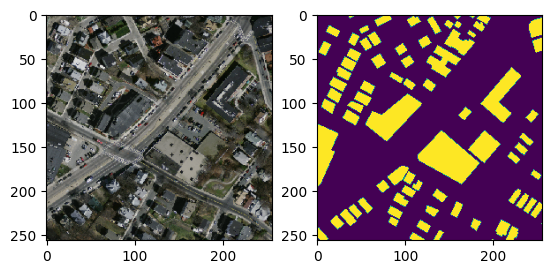

In [31]:
# For Testing

randomImageBatch, randomMaskBatch = random.choice(testGen)

k = random.randint(0, 31)

fig, axes = plt.subplots(1, 2)

axes[0].imshow(randomImageBatch[k])
axes[1].imshow(randomMaskBatch[k])

# Model

In [116]:
def doubleConv(input, filters, dropout):
  x = Conv2D(filters, (3, 3), activation='relu', padding='same')(input)
  x = Dropout(dropout)(x)
  x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
  return x

def doubleUpconv(input, filters, dropout):
  x = Conv2DTranspose(filters, (3, 3), activation='relu', padding='same')(input)
  x = Dropout(dropout)(x)
  x = Conv2DTranspose(filters, (3, 3), strides = (2, 2), activation='relu', padding='same')(x)
  return x

In [137]:
def build_unet(inputs):
    '''Encoder'''
    x_skip_1 = doubleConv(inputs, 32, 0.25)
    x_temp = MaxPooling2D((2,2))(x_skip_1)

    x_skip_2 = doubleConv(x_temp, 64, 0.25)
    x_temp = MaxPooling2D((2,2))(x_skip_2)

    x_skip_3 = doubleConv(x_temp, 128, 0.25)
    x_temp = MaxPooling2D((2,2))(x_skip_3)

    x_temp = doubleConv(x_temp, 128, 0.25)

    '''Decoder'''
    x_temp = doubleUpconv(x_temp, 128, 0.5)
    x_temp = Concatenate()([x_temp, x_skip_3])

    x_temp = doubleUpconv(x_temp, 64, 0.5)
    x_temp = Concatenate()([x_temp, x_skip_2])

    x_temp = doubleUpconv(x_temp, 32, 0.5)
    x_temp = Concatenate()([x_temp, x_skip_1])

    '''Output'''

    x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
    x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
    x_out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x_temp)

    return Model(inputs = inputs, outputs = x_out)

In [140]:
x_in = Input(shape=(256, 256, 3))

model = build_unet(x_in)
model.compile(optimizer = Adam(), loss = "binary_crossentropy", metrics=["accuracy", tf.keras.metrics.BinaryIoU()])
# model.compile(optimizer = Adam(), loss = "binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_33 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_271 (Conv2D)         (None, 256, 256, 32)         896       ['input_33[0][0]']            
                                                                                                  
 dropout_187 (Dropout)       (None, 256, 256, 32)         0         ['conv2d_271[0][0]']          
                                                                                                  
 conv2d_272 (Conv2D)         (None, 256, 256, 32)         9248      ['dropout_187[0][0]']         
                                                                                           

In [141]:
# [batch id, image|mask, index inside the batch ,data]

In [143]:
history = model.fit(trainGen, validation_data=valGen, epochs=25)

Epoch 1/25
97/97 [==============================] - 57s 531ms/step - loss: 0.4601 - accuracy: 0.8566 - binary_io_u: 0.4314 - val_loss: 0.3407 - val_accuracy: 0.8873 - val_binary_io_u: 0.4436
Epoch 2/25
97/97 [==============================] - 51s 521ms/step - loss: 0.3255 - accuracy: 0.8666 - binary_io_u: 0.4333 - val_loss: 0.2676 - val_accuracy: 0.8873 - val_binary_io_u: 0.4436
Epoch 3/25
97/97 [==============================] - 51s 523ms/step - loss: 0.2986 - accuracy: 0.8726 - binary_io_u: 0.4893 - val_loss: 0.2489 - val_accuracy: 0.9077 - val_binary_io_u: 0.6229
Epoch 4/25
97/97 [==============================] - 51s 522ms/step - loss: 0.2702 - accuracy: 0.8913 - binary_io_u: 0.5936 - val_loss: 0.2100 - val_accuracy: 0.9190 - val_binary_io_u: 0.6641
Epoch 5/25
97/97 [==============================] - 51s 522ms/step - loss: 0.2487 - accuracy: 0.8999 - binary_io_u: 0.6299 - val_loss: 0.2127 - val_accuracy: 0.9175 - val_binary_io_u: 0.6840
Epoch 6/25
97/97 [===========================

# Evaluation



In [147]:
# General evaluation: .77 iou on test data
model.evaluate(testGen)

7/7 [==============================] - 1s 132ms/step - loss: 0.1871 - accuracy: 0.9255 - binary_io_u: 0.7719


[0.18713374435901642, 0.9255229830741882, 0.7718988656997681]

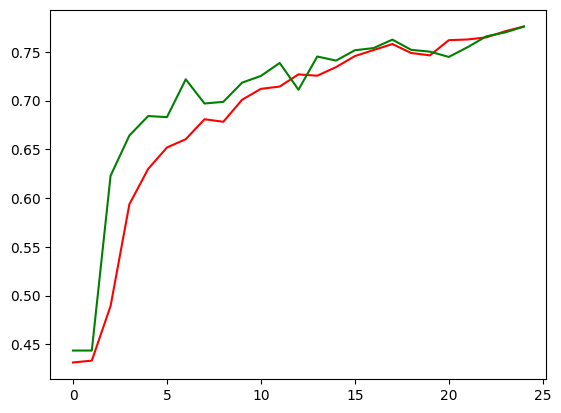

In [156]:
plt.plot(history.history['binary_io_u'], color="red")
plt.plot(history.history['val_binary_io_u'], color="green")

In [157]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'binary_io_u', 'val_loss', 'val_accuracy', 'val_binary_io_u'])

# make a guess

In [160]:
pred_test = model.predict(testGen[0][0])
print("Unique values: ",np.unique(pred_test))

# Since the output of sigmoid activation is between 0 and 1 --> we can threshold it with .5
threshold = .5
pred_test = (pred_test > threshold).astype(np.uint8)
print(pred_test.shape)

1/1 [==============================] - 0s 32ms/step
Unique values:  [6.5766750e-07 7.2689824e-07 8.1631003e-07 ... 9.8241282e-01 9.8274684e-01
 9.8323047e-01]
(32, 256, 256, 1)


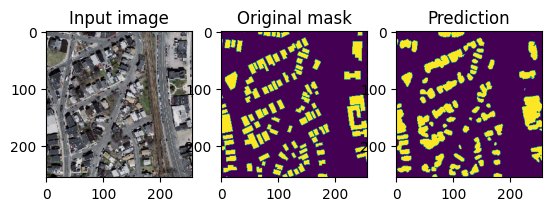

In [208]:
m = random.randint(0, 31)
fig, axes = plt.subplots(1, 3)

axes[0].set_title('Input image')
axes[0].imshow(testGen[0][0][m])

mask_ = testGen[0][1][m][...,0]
pred_ = pred_test[m, :, :, 0]

axes[1].set_title('Original mask')
axes[1].imshow(mask_)

axes[2].set_title('Prediction')
axes[2].imshow(pred_)

In [200]:
model.save('v4.keras')


In [ ]:
with open('/content/drive/MyDrive/buildingSegmentation/history_v4.pkl', 'wb') as f:
  pickle.dump(history.history, f)


In [ ]:
!cp v3.keras /content/drive/MyDrive/buildingSegmentation/v4.keras